In [1]:
# Cài đặt thư viện
!pip install pandas numpy matplotlib seaborn nltk scikit-learn wordcloud plotly tensorflow

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Tải dataset
!kaggle datasets download -d kazanova/sentiment140
!unzip -q sentiment140.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 927MB/s]


In [13]:
# Đọc tập dữ liệu với encoding phù hợp
df = pd.read_csv("training.1600000.processed.noemoticon.csv",
                 encoding='ISO-8859-1',
                 header=None,
                 names=['sentiment', 'id', 'date', 'query', 'user', 'text'])

# Hiển thị thông tin cơ bản
print("Số dòng:", df.shape[0])
print("Các nhãn sentiment:", df['sentiment'].value_counts())

Số dòng: 1600000
Các nhãn sentiment: sentiment
0    800000
4    800000
Name: count, dtype: int64


In [14]:
df['sentiment'] = df['sentiment'].map({0: 'negative', 4: 'positive'})

In [16]:
from nltk.stem import PorterStemmer
# Tạo stopwords và stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Hàm làm sạch văn bản
def clean_tweet(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Áp dụng lên dữ liệu
df['clean_text'] = df['text'].astype(str).apply(clean_tweet)

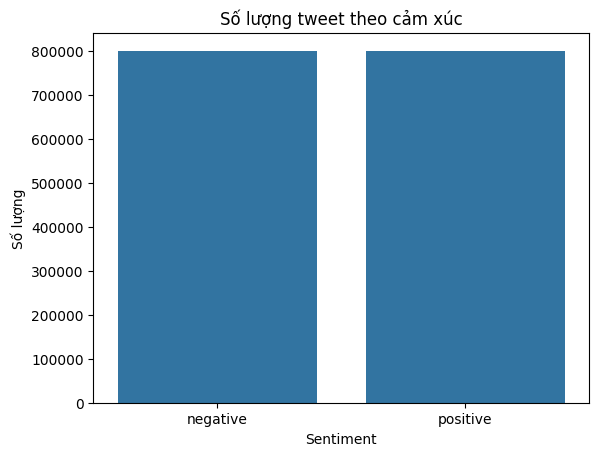

In [17]:
# Phân bố số lượng tweet theo sentiment
sns.countplot(data=df, x='sentiment')
plt.title('Số lượng tweet theo cảm xúc')
plt.xlabel('Sentiment')
plt.ylabel('Số lượng')
plt.show()

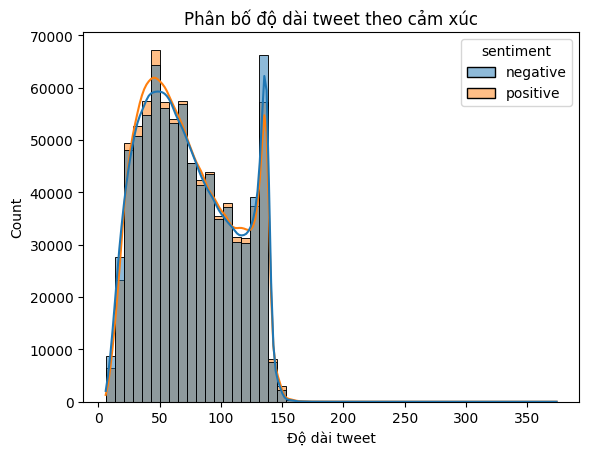

In [18]:
# Độ dài trung bình mỗi tweet
df['tweet_length'] = df['text'].astype(str).apply(len)
sns.histplot(data=df, x='tweet_length', hue='sentiment', bins=50, kde=True)
plt.title('Phân bố độ dài tweet theo cảm xúc')
plt.xlabel('Độ dài tweet')
plt.show()

In [19]:
# Số từ trung bình mỗi tweet
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df.groupby('sentiment')['word_count'].mean()

,word_count
sentiment,
negative,7.328733
positive,6.908416


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Chia tập train/test
X = df['clean_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Huấn luyện Logistic Regression
lr = LogisticRegression(max_iter=1000, C=1.0)
lr.fit(X_train_tfidf, y_train)

# Dự đoán
y_pred_lr = lr.predict(X_test_tfidf)

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Mã hóa nhãn
le = LabelEncoder()
y_lstm = le.fit_transform(y)
y_cat = to_categorical(y_lstm)

# Chuẩn bị dữ liệu
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=50, padding='post')

# Train/Test
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(padded, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# Mô hình LSTM
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=50))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Huấn luyện
history = model.fit(X_train_pad, y_train_pad, validation_data=(X_test_pad, y_test_pad), epochs=5, batch_size=128)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 996s 99ms/step - accuracy: 0.5006 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 951s 95ms/step - accuracy: 0.4982 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1021s 102ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1028s 101ms/step - accuracy: 0.4999 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1059s 102ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932


Logistic Regression Report:
              precision    recall  f1-score   support

    negative       0.78      0.75      0.77    160000
    positive       0.76      0.79      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



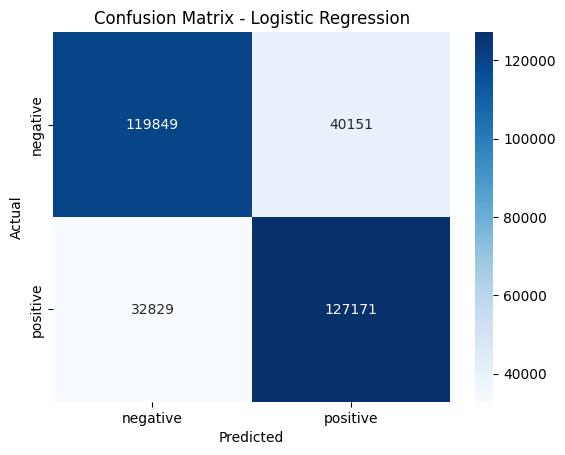

In [22]:
# Classification Report
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 109s 11ms/step
LSTM Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00    160000
    positive       0.50      1.00      0.67    160000

    accuracy                           0.50    320000
   macro avg       0.25      0.50      0.33    320000
weighted avg       0.25      0.50      0.33    320000



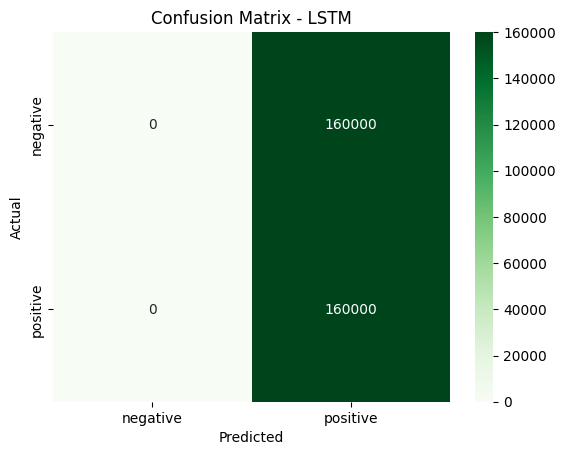

In [23]:
# Dự đoán
y_pred_lstm = model.predict(X_test_pad)
y_pred_labels = le.inverse_transform(y_pred_lstm.argmax(axis=1))
y_test_labels = le.inverse_transform(y_test_pad.argmax(axis=1))

# Classification Report
print("LSTM Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test_labels, y_pred_labels)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

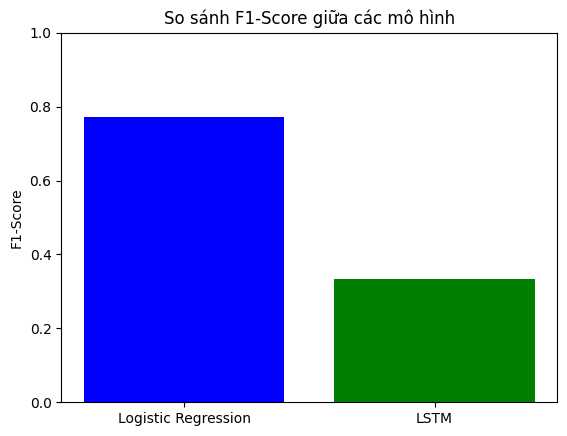

In [24]:
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
f1_lstm = f1_score(y_test_labels, y_pred_labels, average='weighted')

plt.bar(['Logistic Regression', 'LSTM'], [f1_lr, f1_lstm], color=['blue', 'green'])
plt.ylabel('F1-Score')
plt.title('So sánh F1-Score giữa các mô hình')
plt.ylim(0, 1)
plt.show()